<a href="https://colab.research.google.com/github/nkanungo/EVA6/blob/main/DNN_Pytorch_Architecture_Changes_Step8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step8 of architecture changes:**

**Target**: We saw in the last run that the validation accuracy is around 99.44 and very stable as the last 5 epochs were above 99.4. Target Achieved . Then what's this . This one is to enhance the network further and see if we can achieve the accuracy with less than 8000 parameters. But wait, this was supposed to be done in Step-2 . Yes right , but first we wanted to achieve the target of 99.4 with less than 10k steps. Once achieved we need to enhance it further if we can . So let's try  

**Result**: I have got Train accuracy: 98.73   validation accuracy: 99.43   Number of parameters: 7,836

**Analysis**: We changed the number of kernels slightly for the first couple of layers. We know at this layer it extracts edges and gradients and with MNIST we could extract those with lesser feature extractors.Hence with less  number of parameters we achieved the required accuracy 

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dropout_prob=0.1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 12, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(p=dropout_prob)
        ) # Input=28, Output=28, rf=3
        self.conv2 = nn.Sequential(
            nn.Conv2d(12, 12, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(p=dropout_prob)
        ) # Input=28, Output=28, rf=5

        self.pool1= nn.MaxPool2d(2, 2) # Input=28, Output=14, rf=6

        self.conv3 = nn.Sequential(
            nn.Conv2d(12, 14, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout2d(p=dropout_prob) # Input=14, Output=14, rf=10
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(14, 14, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout2d(p=dropout_prob) # Input=14, Output=14, rf=14
        )

        self.pool2= nn.MaxPool2d(2, 2) # Input=14, Output=7, rf=16

        self.conv5 = nn.Sequential(
            nn.Conv2d(14, 14, 3, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout2d(p=dropout_prob) # Input=7, Output=5, rf=24
        )


       
        self.conv6 = nn.Sequential(
            nn.Conv2d(14, 10, 3, padding=0, bias=False),
        ) # Input=5, Output=3, rf=32

        self.global_avgpool = nn.AdaptiveAvgPool2d(1)  # Input=3, Output=1, rf=40
      
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
               
        x = self.global_avgpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             108
              ReLU-2           [-1, 12, 28, 28]               0
       BatchNorm2d-3           [-1, 12, 28, 28]              24
         Dropout2d-4           [-1, 12, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]           1,296
              ReLU-6           [-1, 12, 28, 28]               0
       BatchNorm2d-7           [-1, 12, 28, 28]              24
         Dropout2d-8           [-1, 12, 28, 28]               0
         MaxPool2d-9           [-1, 12, 14, 14]               0
           Conv2d-10           [-1, 14, 14, 14]           1,512
             ReLU-11           [-1, 14, 14, 14]               0
      BatchNorm2d-12           [-1, 14, 14, 14]              28
        Dropout2d-13           [-1, 14, 14, 14]               0
           Conv2d-14           [-1, 14,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [8]:


#torch.manual_seed(11)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.19, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.016410106793045998 Batch_id=937 Accuracy=93.24: 100%|██████████| 938/938 [00:19<00:00, 48.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Loss=0.21783547103405 Batch_id=937 Accuracy=96.85: 100%|██████████| 938/938 [00:19<00:00, 48.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.015284744091331959 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:19<00:00, 48.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.2492150068283081 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:19<00:00, 47.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.0245816707611084 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:19<00:00, 48.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.13184338808059692 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:19<00:00, 48.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.0024954259861260653 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:19<00:00, 47.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.1275566965341568 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:19<00:00, 48.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.01637805812060833 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:19<00:00, 47.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.07152630388736725 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:19<00:00, 48.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.005180791951715946 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:19<00:00, 49.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.0043367319740355015 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:19<00:00, 47.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.02045714668929577 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:19<00:00, 47.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.01359009463340044 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:19<00:00, 48.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.006432771682739258 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:19<00:00, 47.88it/s]



Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)



In [2]:
import matplotlib.pyplot as plt
def plot_accuracy(train_accuracy_list, test_accuracy_list):
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(train_acc, label="Train Accuracy")
    axs.plot(test_acc, label="Test Accuracy")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

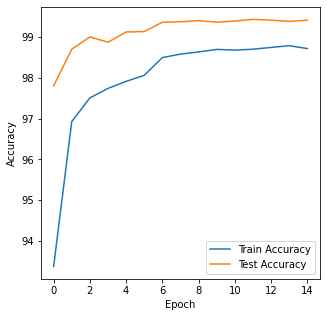

In [6]:
plot_accuracy(train_acc, test_acc)